In [498]:
import json
import os
from pprint import pprint
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm, remove_weight_norm
import torch.nn.functional as F
import scipy
from scipy.io import wavfile, loadmat, savemat
import sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, root_mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import librosa
from itertools import combinations
from collections import Counter
import time
plt.rcParams['figure.figsize'] = (10, 5)

In [421]:
LRELU_SLOPE = 0.1
VALANCE_FACTOR, AROUSAL_FACTOR = 8, 8
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [431]:
low, srl = librosa.load("low.m4a")
high, srh = librosa.load("high.m4a")
low

/var/folders/0f/x7xs6kjs6k7dfph84ymzzlrr0000gn/T/ipykernel_54968/3975378833.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  low, srl = librosa.load("low.m4a")
/var/folders/0f/x7xs6kjs6k7dfph84ymzzlrr0000gn/T/ipykernel_54968/3975378833.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  high, srh = librosa.load("high.m4a")


array([-0.00074496, -0.00117482, -0.00105143, ...,  0.00134376,
        0.00135215,  0.00133266], dtype=float32)

In [394]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=3)

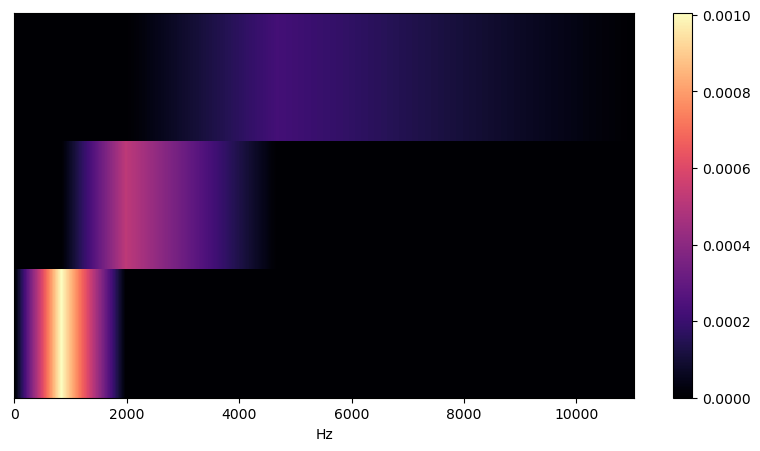

In [395]:
librosa.display.specshow(filter_banks, sr=22050, x_axis='linear')
plt.colorbar()
plt.show()

In [396]:
mel_low = librosa.feature.melspectrogram(y=low, sr=22050, n_fft=2048, hop_length=512, n_mels=100)
log_low = librosa.power_to_db(mel_low)
mel_high = librosa.feature.melspectrogram(y=high, sr=22050, n_fft=2048, hop_length=512, n_mels=100)
log_high = librosa.power_to_db(mel_high)

NameError: name 'low' is not defined

NameError: name 'log_low' is not defined

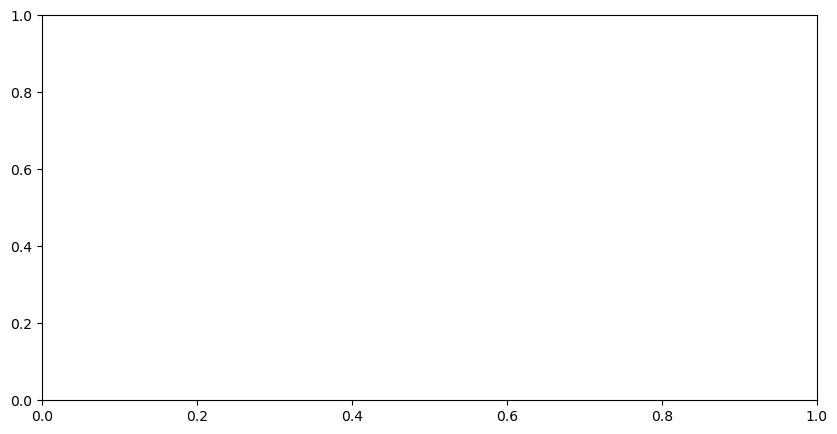

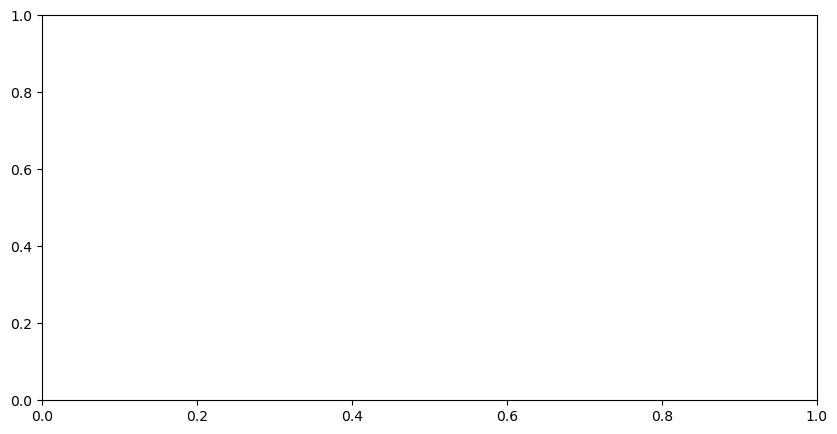

In [397]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
librosa.display.specshow(log_low, x_axis="time", y_axis="mel", sr=22050, ax=ax1)
librosa.display.specshow(log_high, x_axis="time", y_axis="mel", sr=22050, ax=ax2)

In [398]:
def audio_to_spectrogram(audiofiles, n_fft, n_mels, hop_length, sr=22050):
    if isinstance(audiofiles, str):
        audiofiles = [audiofiles]
    for audiofile in audiofiles:
        try:
            audio, sr = librosa.load(audiofile, sr=sr)
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            return mel
        except e:
            print(f"Error generating spectgram for {audiofile}: {e}")

In [479]:
# Input will be EEG signals with IN_CH electrodes
# Output will be mel spectrogram with OUT_CH mel bands
IN_CH = 31
OUT_CH = 100

class Generator(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(Generator, self).__init__()

        self.num_ups = 3
        
        # Upsample data to some high nuumber of channels to have many possible features
        self.conv_pre = nn.Conv1d(IN_CH, channels, kernel_size=3)
        
        # Downsample data incrementally to combine features and form the mel spectrogram
        # This is called upsampling because ConvTranspose has an upsamplig property
        self.ups = nn.ModuleList()
        for i in range(self.num_ups):
            self.ups.append(
                nn.ConvTranspose1d(in_channels=channels, out_channels=channels//2,
                                                 kernel_size=kernel_size, stride=1)
            )
            channels //= 2

        # Downsample data to the desired number of mel bands
        self.conv_post = nn.Conv1d(channels, OUT_CH, kernel_size=5)

    def forward(self, x):
        x = self.conv_pre(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        for up in self.ups:
            x = up(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
        x = self.conv_post(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        x = torch.sigmoid(x)
        return x
            


In [480]:

class Discriminator(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(Discriminator, self).__init__()

        self.num_downs = 3
        
        # Upsample from input channels to a large number of channels
        self.conv_pre = nn.Conv1d(OUT_CH, channels, kernel_size=3)
        
        # Upsample data incrementally to extract relevant features
        # This is referred to as downsample because we use Conv layer which has a downsampling property 
        self.downs = nn.ModuleList()
        for i in range(self.num_downs):
            self.downs.append(
                nn.Conv1d(in_channels=channels, out_channels=channels*2,
                                                 kernel_size=kernel_size, stride=1)
            )
            channels *= 2

        # Downsample data to the desired number of channels to compare generator spectrogram with 
        # actual spectrogram
        self.conv_post = nn.ConvTranspose1d(channels, OUT_CH, kernel_size=9)

        # FC Layer to get the relative valance and arousal
        self.adv = nn.Sequential(nn.Linear(OUT_CH, 1), nn.Sigmoid())
        self.aux_val = nn.Sequential(nn.Linear(OUT_CH, 1), nn.Sigmoid())
        self.aux_aro = nn.Sequential(nn.Linear(OUT_CH, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.conv_pre(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        for down in self.downs:
            x = down(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
        x = self.conv_post(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        x = x.transpose(1, 2)
        
        y = x.clone()
        y = self.adv(y)
        
        validity = torch.mean(y, dim=(0, 1))
        val = x.clone()
        val = self.aux_val(val) * VALANCE_FACTOR
        val = val.transpose(1, 2)
        val = val.view(1, -1)
        
        aro = x.clone()
        aro = self.aux_aro(x) * AROUSAL_FACTOR
        aro = aro.transpose(1, 2)
        aro = aro.view(1, -1)
        
        return (validity, val, aro)

In [499]:


def train(num_epochs, inputs, targets, target_val, target_aro, models, criteria, optimizers):

    (model_g, model_d) = models
    (criterion_recon, criterion_adv, criterion_val, criterion_aro) = criteria
    (optimizer_g, optimizer_d) = optimizers
    
    epoch_loss_g = [[] for _ in range(num_epochs)]
    epoch_acc_g = [[] for _ in range(num_epochs)]
    epoch_loss_d = [[] for _ in range(num_epochs)]
    epoch_acc_d = [[] for _ in range(num_epochs)]
    
    # For loop which runs for num_epochs
    for e in range(num_epochs):

        for n, (i, t, tv, ta) in enumerate(zip(inputs, targets, target_val, target_aro)):
            
            # train_G and train_D
            outputs, e_loss_g, e_acc_g = train_G(i, t, (model_g, model_d), 
                                                (criterion_recon, criterion_adv),
                                                optimizer_g)
    
            e_loss_d, e_acc_d = train_D(outputs, t, tv, ta, (model_g, model_d),
                                        (criterion_adv, criterion_val, criterion_aro),
                                        optimizer_d)
            print(f"Traiing Epoch {e+1} [{n+1}/{len(inputs)}]: Training losses {e_loss_g}, {e_loss_d}")
            epoch_loss_g[e].append(e_loss_g)
            epoch_acc_g[e].append(e_acc_g)
            epoch_loss_d[e].append(e_loss_d)
            epoch_acc_d[e].append(e_acc_d)
            time.sleep(5)
            

    return models, epoch_loss_g, epoch_acc_g, epoch_loss_d, epoch_acc_d
            
def train_G(inputs, targets, models,  criteria, optimizer_g):

    model_g, model_d = models
    criterion_recon, criterion_adv = criteria
    
    for p in model_g.parameters():
        p.requires_grad_(True)
    for p in model_d.parameters():
        p.requires_grad_(False)

    # Training generator, so all labels are 100% real
    valid = torch.ones((1), dtype = torch.float32)
    
    # Zero grad
    optimizer_g.zero_grad()
    
    # Forward pass of geenrator
    outputs = model_g(inputs)
    mel_out = outputs.clone()
    #print("mel_out1", mel_out)
    mel_out = mel_out.view(1, *mel_out.shape)
    g_valid, _, _ = model_d(mel_out)
    
    # Calculate Loss with different criteria for generator
    loss_recon = criterion_recon(mel_out, targets)
    
    loss_adv = criterion_adv(g_valid, valid)
    acc_g = (g_valid.round() == valid).float().mean()

    loss_g = 0.2*loss_recon + 0.5*loss_adv
    # Step gradient
    loss_g.backward()
    optimizer_g.step()

    e_loss_g = (loss_g.item(), loss_recon.item(), loss_adv.item())
    e_acc_g = (acc_g.item())
    
    return (mel_out, e_loss_g, e_acc_g)

def train_D(mel_out, targets, target_val, target_aro, models, criteria, optimizer_d):

    (model_g, model_d) = models
    (criterion_adv, criterion_val, criterion_aro) = criteria

    for p in model_g.parameters():
        p.requires_grad_(False)
    for p in model_d.parameters():
        p.requires_grad_(True)

    valid = torch.ones((1), dtype=torch.float32)
    fake = torch.zeros((1), dtype=torch.float32)
    
    # Zero grad
    optimizer_d.zero_grad()
    
    # Forward pass of discriminator
    real_valid, real_val, real_aro = model_d(targets)
    fake_valid, fake_val, fake_aro = model_d(mel_out.detach())

    # Calculate Loss with different criteria for discriminator
    loss_d_real_valid = criterion_adv(real_valid, valid)
    loss_d_fake_valid = criterion_adv(fake_valid, fake)

    loss_d_real_val = criterion_val(real_val, target_val)
    loss_d_real_aro = criterion_aro(real_aro, target_aro)

    loss_d_valid = 0.5 * (loss_d_real_valid + loss_d_fake_valid)
    loss_d_cl = loss_d_real_val + loss_d_real_aro
    loss_d = loss_d_valid + loss_d_cl
    
    acc_d_real = (real_valid.round() == valid).float().mean()
    acc_d_fake = (fake_valid.round() == fake).float().mean()
    
    # Step gradient
    loss_d.backward()
    optimizer_d.step()

    e_loss_d = (loss_d.item(), loss_d_valid.item(), loss_d_cl.item())
    e_acc_d = (acc_d_real.item(), acc_d_fake.item())

    return e_loss_d, e_acc_d
    

In [500]:
def RMSELoss(pred, actual):
    return torch.sqrt(torch.mean((pred - actual)**2))    

In [501]:
 # stepping up number of channels in generater and discriminator to INIT_UP and INIT_DOWN number of channels
INIT_UP = 1024
INIT_DOWN = 64

#inputs = torch.rand((1, 4, 1000), dtype=torch.float32)
#targets = torch.rand((1, 1, 100, 1000), dtype=torch.float32)
#target_val = torch.rand((1, 1, 1000), dtype=torch.float32)
#target_val = np.absolute(target_val) * VALANCE_FACTOR / max(target_val)
#target_aro = torch.rand((1, 1, 1000), dtype=torch.float32)
#target_aro = np.absolute(target_aro) * AROUSAL_FACTOR / max(target_aro)

df = pd.read_csv("collapsed_data.csv")

sr=22050
n_fft=2048
hop_length=512

inputs = np.array(df[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
       'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz',
       'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10',
       'POz']])

num_sessions = 11
inputs = np.array([inputs[(i*1000):((i+1)*1000)].transpose() for i in range(num_sessions)])
print(np.shape(inputs))
x = [752, 451, 281, 751, 282, 1052, 752, 281, 821, 822, 451]
songsnames = [(j,"".join([str(i)[:-2], "-", str(i)[-2], "_", str(i)[-1]])) for j, i in enumerate(x) if i < 1000]

target_val = df["ft_valance"]
target_val = np.array([np.array([target_val[(i*1000):((i+1)*1000)]]) for i in range(num_sessions)])

target_aro = df["ft_arousal"]
target_aro = np.array([np.array([target_aro[(i*1000):((i+1)*1000)]]) for i in range(num_sessions)])

songs = []
temp = []
temp2 = []
temp3 = []
for i, s in songsnames:
    f = audio_to_spectrogram(f"daly_2019/stimuli/generated/{s}.wav", n_fft, OUT_CH, hop_length).transpose()[:1000].transpose()
    songs.append(np.array([f]))
    temp.append(inputs[i])
    temp2.append(target_val[i])
    temp3.append(target_aro[i])
inputs = torch.tensor(temp, dtype=torch.float32)
targets = torch.tensor(songs, dtype=torch.float32)
target_val = torch.tensor(temp2, dtype=torch.float32)
target_aro = torch.tensor(temp3, dtype=torch.float32)
print(inputs.shape)
print(targets.shape)
print(target_val.shape)
print(target_aro.shape)

# Initialise models
model_g = Generator(INIT_UP)
model_d = Discriminator(INIT_DOWN)
models = (model_g, model_d)

# Initialise criteria
criterion_recon = RMSELoss
criterion_adv = nn.BCELoss()
criterion_val = RMSELoss
criterion_aro = RMSELoss
criteria = (criterion_recon, criterion_adv, criterion_val, criterion_aro)

# Initialise optimisers
optimizer_g = torch.optim.AdamW(model_g.parameters(), lr=1e-3, weight_decay=1e-3)
optimizer_d = torch.optim.AdamW(model_d.parameters(), lr=1e-3, weight_decay=1e-3)
optimizers = (optimizer_g, optimizer_d)

(trained_g, trained_d), epoch_loss_g, epoch_acc_g, epoch_loss_d, epoch_acc_d = train(10, inputs, targets, target_val, target_aro, models, criteria, optimizers)



(11, 31, 1000)
torch.Size([10, 31, 1000])
torch.Size([10, 1, 100, 1000])
torch.Size([10, 1, 1000])
torch.Size([10, 1, 1000])
Traiing Epoch 1 [1/10]: Training losses (6.86666202545166, 32.664424896240234, 0.6675539016723633), (7.743377685546875, 0.6352424621582031, 7.108135223388672)
Traiing Epoch 1 [2/10]: Training losses (1.0670349597930908, 3.7140181064605713, 0.6484625339508057), (5.833017826080322, 0.6136791110038757, 5.219338893890381)
Traiing Epoch 1 [3/10]: Training losses (4.544344425201416, 21.23048973083496, 0.5964928865432739), (5.637036323547363, 0.5921715497970581, 5.044864654541016)
Traiing Epoch 1 [4/10]: Training losses (8.25694465637207, 40.03822326660156, 0.4985996186733246), (2.2141900062561035, 0.4980606734752655, 1.7161294221878052)
Traiing Epoch 1 [5/10]: Training losses (1.4994354248046875, 6.50584077835083, 0.39653435349464417), (2.920872449874878, 0.634494960308075, 2.286377429962158)
Traiing Epoch 1 [6/10]: Training losses (6.679638385772705, 32.61483764648437

In [486]:
sample = trained_g(inputs).detach().numpy()
sample.shape

(10, 100, 1000)

(100, 100, 2)
(100, 100, 2)


/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1000
  warnings.warn(


TypeError: 'module' object is not callable

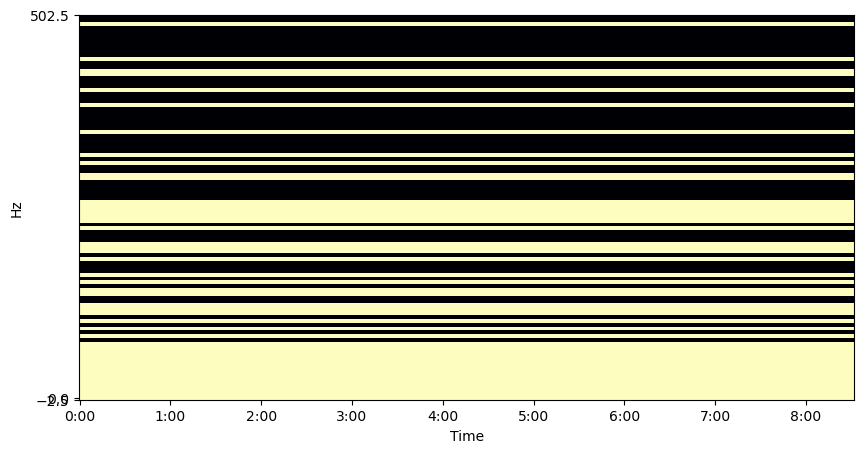

In [487]:
n_fft = 2048
n_mels = 100
hop_length = 512
sr = 1000
S = librosa.feature.melspectrogram(y=sample[0], sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
print(S.shape)
S_DB = librosa.power_to_db(S, ref=np.max)
print(S_DB.shape)
fig1, ax1 = plt.subplots()
librosa.display.specshow(sample[0], x_axis="time", y_axis="mel", sr=sr, ax=ax1)
librosa.feature.inverse(sample[0])

In [382]:
VALANCE_FACTOR = 8
AROUSAL_FACTOR = 8
IN_CH_EEG = 4
IN_CH_SONG = 100
OUT_CH = 20

class PredicationModel(nn.Module):
    def __init__(self):
        self.mid_channels = 1024
        
        super(PredicationModel, self).__init__()
        self.conv1 = nn.Conv1d(IN_CH_EEG, OUT_CH*10, kernel_size=3)
        self.conv2 = nn.Conv1d(OUT_CH*10, OUT_CH, kernel_size=3)

        self.conv21 = nn.Conv1d(IN_CH_SONG, OUT_CH*10, kernel_size=3)
        self.conv22 = nn.Conv1d(OUT_CH*10, OUT_CH, kernel_size=3)

        self.aux_val = nn.Sequential(nn.Linear(OUT_CH, 1), nn.Sigmoid())
        self.aux_aro = nn.Sequential(nn.Linear(OUT_CH, 1), nn.Sigmoid())
    
    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x1 = F.leaky_relu(x1, LRELU_SLOPE)
        x1 = self.conv2(x1)
        x1 = F.leaky_relu(x1, LRELU_SLOPE)
        
        x2 = self.conv21(x2)
        x2 = F.leaky_relu(x2, LRELU_SLOPE)
        x2 = self.conv22(x2)
        x2 = F.leaky_relu(x2, LRELU_SLOPE)
        
        x1 = x1.view(-1, OUT_CH)
        x2 = x2.view(-1, OUT_CH)
        
        x = torch.cat([x1, x2], dim=0)
        val = x.clone()
        val = self.aux_val(val) * VALANCE_FACTOR
        val = torch.mean(val, dim=0)
        aro = x.clone()
        aro = self.aux_aro(aro) * AROUSAL_FACTOR
        aro = torch.mean(aro, dim=0)
        return (val, aro)

In [383]:
def train_simple(num_epochs, X1, X2, y1, y2, model, criteria, optimizer):
    (criterion_val, criterion_aro) = criteria

    for e in range(num_epochs):
        print(f"Epoch {e} / {num_epochs}")
        for i, (eeg_data, song_data, val, aro) in enumerate(zip(X1, X2, y1, y2)):
            optimizer.zero_grad()
            
            val_pred, aro_pred = model(eeg_data, song_data)

            loss_val = criterion_val(val_pred, val)
            loss_aro = criterion_aro(aro_pred, aro)

            loss = loss_val + loss_aro

            loss.backward()
            optimizer.step()
            print(f"Item {i}: {loss}")
            
    return model

In [384]:

EEG_data = torch.rand((1, IN_CH_EEG, 10000), dtype=torch.float32)*7
song_data = torch.rand((1, IN_CH_SONG, 1000), dtype=torch.float32)*10
val = torch.rand((1, 1), dtype=torch.float32)
aro = torch.rand((1, 1), dtype=torch.float32)

model = PredicationModel()

criterion_val = RMSELoss
criterion_aro = RMSELoss
criteria = (criterion_val, criterion_aro)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-2)

m2 = train_simple(6, EEG_data, song_data, val, aro, model, criteria, optimizer)

Epoch 0 / 6
Item 0: 6.565237045288086
Epoch 1 / 6
Item 0: 1.3392369747161865
Epoch 2 / 6
Item 0: 0.9739797711372375
Epoch 3 / 6
Item 0: 0.8434419631958008
Epoch 4 / 6
Item 0: 0.8101158142089844
Epoch 5 / 6
Item 0: 0.7475597262382507


In [385]:
print(m2(EEG_data[0], song_data[0]))
val, aro

(tensor([0.2388], grad_fn=<MeanBackward1>), tensor([0.2595], grad_fn=<MeanBackward1>))


(tensor([[0.5402]]), tensor([[0.4982]]))